# HELIO-LEARNING
## Space Weather Prediction using Deep Learning

#### COLLABORATORS
> - #### __Sukumar Hakhoo__
> - #### __Agnit Mukhopadhyay__

#### IDEA
The project will utilize Deep Learning to predict upper-atmospheric (ionospheric) electrical conductance in the aurora/polar regions. The auroral conductance is severely affected by space weather phenomena like solar flares and coronal mass ejections (CMEs).  This project will enable significant improvements in present predictive investigations into the physics and estimation of the auroral conductance.

#### PROBLEM
Global magnetohydrodynamic (MHD) models are used predominantly in space weather prediction. In almost all such global models, the estimation of the ionospheric conductance is conducted using outdated empirical models. This poses a massive challenge, when predicting quantities like the conductance in the aurora/polar region, which are driven mostly by electromagnetic interactions with charged particles, that MHD cannot predict accurately.

We, therefore, intend to use dense neural networks to predict this quantity using inputs from in-situ satellite data and ground-based instruments. This predictive model will be designed to take multiple inputs and return the conductance as an output. Once operational, the model will be installed into the University of Michigan’s Space Weather Modeling Framework (SWMF) to study improvements in space weather predictive skill.

##### __IMPORTS__

In [1]:
import os.path
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir
import scipy.io as scio
import matplotlib.pyplot as plt
from os.path import isdir, isfile
from sklearn.model_selection import train_test_split

# import numpy.ma as ma
# import datetime as dt
# import pickle

### __DATA ETL__
The data for each day is present in an IDL *.save* file.
This data is obtained directly from the dataset, Assimilative Mapping of Ionospheric Electrodynamics (AMIE).
#### Data Directory structure
    Data
    |-- year
        |-- month
            |-- day.save

#### Checking data characteristics using any one of the data files

In [2]:
# Globals

DATA_DIR = 'Data'
FIELDS_TO_CONSIDER = ['hall conductance (aurora)', 'pedersen conductance (aurora)', 'field-aligned current']
FIELD_NAMES = ['Hall Conductance (Aurora)', 'Pedersen Conductance (Aurora)', 'Field-Aligned Current']
FIELD_SHORT_NAMES = ['h', 'p', 'f']
FILE_LIMIT = 2

In [3]:
def get_random_file():
    years = listdir(DATA_DIR)
    if years:
        random_year = years[0]
        if isdir(DATA_DIR + '/' + random_year):
            months = listdir(DATA_DIR + '/' + random_year)
            if months:
                random_month = months[0]
                if isdir(DATA_DIR + '/' + random_year + '/' + random_month):
                    dates = listdir(DATA_DIR + '/' + random_year + '/' + random_month)
                    if dates:
                        file_name = DATA_DIR + '/' + random_year + '/' + random_month + '/' + dates[0]
                        return file_name

    print('Data unavailable')

In [4]:
f = get_random_file()

In [5]:
if os.path.isfile(f):
    print('AMIE File')
    a = scio.readsav(f)
    for key in a:
        if isinstance(a[key], np.ndarray):
            print('{:<20} = '.format(f'amie[{key}].shape') + str(a[key].shape))
        else:
            print('{:<20} = '.format(f'amie[{key}]') + str(a[key]))
            
    print('\nFields available: \n- ', end = '')
    print('\n- '.join([i.decode("utf-8").strip() for i in a['fields']]))

AMIE File
amie[amie_file]      = b'b20040101n'
amie[data].shape     = (24, 25, 19, 1440)
amie[lats].shape     = (24,)
amie[mlts].shape     = (25,)
amie[time].shape     = (1440,)
amie[fields].shape   = (19,)
amie[imf].shape      = (4, 1440)
amie[ae].shape       = (4, 1440)
amie[dst].shape      = (2, 1440)
amie[hp].shape       = (2, 1440)
amie[cpcp].shape     = (1440,)
amie[version]        = 2.22

Fields available: 
- electric potential
- pedersen conductance (total)
- pedersen conductance (aurora)
- hall conductance (total)
- hall conductance (aurora)
- auroral mean energy (kev)
- auroral energy flux (er/cm2/s)
- electric field (east)
- electric field (north)
- horizontal current (east)
- horizontal current (north)
- horizontal current (magnitude)
- simple joule heating
- auroral mean energy (model)
- auroral energy flux (model)
- pedersen conductance model
- hall conductance model
- potential model
- field-aligned current (!Mm!XA/m!E2!N)


#### Loading all data files

In [6]:
def dataset_metadata_generator():
    location = DATA_DIR
    years = listdir(location)
    for year in years:
        if isdir(location + '/' + year):
            location += '/' + year

            months = listdir(location)
            for month in months:
                if isdir(location + '/' + month):
                    location += '/' + month

                    dates = listdir(location)
                    for date in dates:
                        file_name = location + '/' + date
                        yield year, month, date[7:9], file_name                    

In [7]:
def read_dataset(year, month, date, file_name):
    print(f'Processing file: {year}/{month}/{date}', end=' ')
    if os.path.isfile(file_name):
        a = scio.readsav(file_name)
        
        Fields = [i.decode("utf-8").strip() for i in a['fields']]
        field_indices = [i for field in FIELDS_TO_CONSIDER for i, key in enumerate(Fields) if field in key]
        
        dataset = np.zeros((a['time'].shape[0] * a['lats'].shape[0] * a['mlts'].shape[0], 9))
        
        year, month, date = int(year), int(month), int(date)
        
        row_num = -1
        p = a['time'].shape[0] // 10
        for time_ in range(a['time'].shape[0]):
            if time_ % p == 0:
                print('.', end='')
            for lat in range(a['lats'].shape[0]):
                for mlt in range(a['mlts'].shape[0]):
                    row_num += 1
                    dataset[row_num] = [year,
                                        month,
                                        date,
                                        time_,
                                        a['lats'][lat],
                                        a['mlts'][mlt],
                                        a['data'][lat][mlt][field_indices[0]][time_],
                                        a['data'][lat][mlt][field_indices[1]][time_],
                                        a['data'][lat][mlt][field_indices[2]][time_]]
        print(' [processed]')
        return dataset
    print(f'File not found: {file_name}')

In [11]:
data = None

print('Reading data files.')
for i, detail in enumerate(dataset_metadata_generator()):
    if i + 1 > FILE_LIMIT:
        break
    
    if data is not None:
        data = np.vstack((data, read_dataset(*detail)))
    else:
        data = read_dataset(*detail)
        
print('Shape of loaded data: ' + str(data.shape))

Reading data files.
Processing file: 2004/01/01 .......... [processed]
Processing file: 2004/01/02 .......... [processed]
Shape of loaded data: (1728000, 9)


In [12]:
columns = ['Year', 'Month', 'Date', 'Time', 
           'Latitude', 'MLT', 
           'Hall Conductance (Aurora)', 
           'Pedersen Conductance (Aurora)', 
           'Field-aligned current']

data_df = pd.DataFrame(data, columns=columns)
data_df

,Year,Month,Date,Time,Latitude,MLT,Hall Conductance (Aurora),Pedersen Conductance (Aurora),Field-aligned current
0,2004.0,1.0,1.0,0.0,90.000000,0.0,0.603387,0.686359,-0.000000
1,2004.0,1.0,1.0,0.0,90.000000,1.0,0.603387,0.686359,-0.000000
2,2004.0,1.0,1.0,0.0,90.000000,2.0,0.603387,0.686359,-0.000000
3,2004.0,1.0,1.0,0.0,90.000000,3.0,0.603387,0.686359,-0.000000
4,2004.0,1.0,1.0,0.0,90.000000,4.0,0.603387,0.686359,-0.000000
...,...,...,...,...,...,...,...,...,...
1727995,2004.0,1.0,2.0,1439.0,44.000004,20.0,0.276593,0.295475,0.003026
1727996,2004.0,1.0,2.0,1439.0,44.000004,21.0,0.269563,0.286469,0.003207
1727997,2004.0,1.0,2.0,1439.0,44.000004,22.0,0.286481,0.301729,0.003132
1727998,2004.0,1.0,2.0,1439.0,44.000004,23.0,0.272100,0.287711,0.002728


In [13]:
data_df[data_df['Field-aligned current'] > 0].head()

,Year,Month,Date,Time,Latitude,MLT,Hall Conductance (Aurora),Pedersen Conductance (Aurora),Field-aligned current
25,2004.0,1.0,1.0,0.0,88.0,0.0,0.747512,0.852444,0.001673
26,2004.0,1.0,1.0,0.0,88.0,1.0,0.705329,0.796412,0.004226
27,2004.0,1.0,1.0,0.0,88.0,2.0,0.890293,0.957106,0.002421
37,2004.0,1.0,1.0,0.0,88.0,12.0,0.842969,1.029214,0.001316
38,2004.0,1.0,1.0,0.0,88.0,13.0,0.760856,0.940128,0.007792


In [14]:
train, test = train_test_split(data_df, train_size=0.8)
train.shape, test.shape

((1382400, 9), (345600, 9))

In [15]:
features = ['Year', 'Month', 'Date', 'Time', 
            'Latitude', 'MLT', 
            'Field-aligned current']

MODE = 'hall'
if MODE == 'hall':
    label =  'Hall Conductance (Aurora)'
else: 
    label = 'Pedersen Conductance (Aurora)'

x_train = train[features].values
y_train = train[label].values
x_test = test[features].values
y_test = test[label].values

### __DATA VISUALIZATION__

#### Visualizing a data file

In [16]:
first_row_detail = data_df.iloc[0].Year, data_df.iloc[0].Month, data_df.iloc[0].Date

In [17]:
first_date_df = data_df[(data_df['Year'] == first_row_detail[0]) & 
                        (data_df['Month'] == first_row_detail[1]) & 
                        (data_df['Date'] == first_row_detail[2])]
first_date_df

,Year,Month,Date,Time,Latitude,MLT,Hall Conductance (Aurora),Pedersen Conductance (Aurora),Field-aligned current
0,2004.0,1.0,1.0,0.0,90.000000,0.0,0.603387,0.686359,-0.000000
1,2004.0,1.0,1.0,0.0,90.000000,1.0,0.603387,0.686359,-0.000000
2,2004.0,1.0,1.0,0.0,90.000000,2.0,0.603387,0.686359,-0.000000
3,2004.0,1.0,1.0,0.0,90.000000,3.0,0.603387,0.686359,-0.000000
4,2004.0,1.0,1.0,0.0,90.000000,4.0,0.603387,0.686359,-0.000000
...,...,...,...,...,...,...,...,...,...
863995,2004.0,1.0,1.0,1439.0,44.000004,20.0,0.263267,0.282453,-0.000013
863996,2004.0,1.0,1.0,1439.0,44.000004,21.0,0.259908,0.276464,0.000632
863997,2004.0,1.0,1.0,1439.0,44.000004,22.0,0.265354,0.284564,0.001484
863998,2004.0,1.0,1.0,1439.0,44.000004,23.0,0.269870,0.289261,0.002305


In [ ]:
# sns.pairplot(first_date_df[['Latitude', 'MLT', 'Field-aligned current', 'Hall Conductance (Aurora)']], hue='MLT', diag_kind='kde')

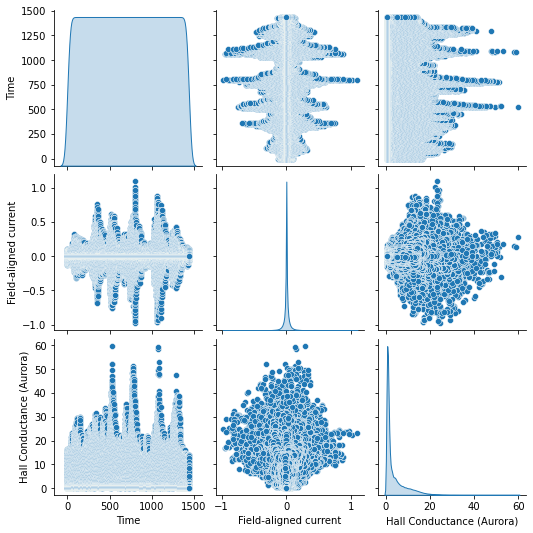

In [20]:
sns.pairplot(first_date_df[['Time', 'Field-aligned current', 'Hall Conductance (Aurora)']], diag_kind='kde')

In [ ]:
# sns.pairplot(first_date_df[['Latitude', 'MLT', 'Field-aligned current', 'Hall Conductance (Aurora)']], kind='kde')

### __MODEL TRAINING__

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adagrad, RMSprop, Adadelta, Adam, Nadam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers.experimental import preprocessing

#### Compiling the model

In [44]:
train.describe().transpose()[['mean', 'std']]

,mean,std
Year,2004.000000,0.000000
Month,1.000000,0.000000
Date,1.500075,0.500000
Time,719.193239,415.654283
Latitude,67.012643,13.844906
MLT,12.002356,7.210532
Hall Conductance (Aurora),3.367452,4.360690
Pedersen Conductance (Aurora),2.736191,2.989437
Field-aligned current,0.000243,0.047587


In [48]:
normalizer = preprocessing.Normalization(input_shape=[7,])
normalizer.adapt(train[features].values)

In [49]:
seed = 10
model = Sequential([
    normalizer,
    Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
    Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
    Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
    Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
    Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
    Dense(100, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='relu'),
    Dense(1, kernel_initializer=he_normal(seed=seed), bias_initializer='zeros', activation='softmax')
])


    
#     model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
#                     bias_initializer=bias_initializer))

In [50]:
# model.compile(optimizer=tf.keras.optimizers.SGD(nesterov=True),
#                   loss='mean_squared_error',
#                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
              loss='mean_absolute_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

#### Fitting the model on the training data

In [ ]:
model.fit(
        x = x_train,
        y = y_train,
        batch_size=128,
        epochs=10,
        verbose=1
    )

#### Evaluation

In [41]:
model.evaluate(x=x_test, y=y_test)

10800/10800 [==============================] - 23s 2ms/step - loss: 2.7386 - root_mean_squared_error: 4.9649


[2.738638162612915, 4.964892864227295]

#### Data Processing

The data in the raw dataset is present as a multi-dimensional array. Each dimension denotes a particular feautre or label.

Hence, the data is processed by flattening the raw data into a 2-dimensional array which has two labels in the beginning followed by three features.

The processing of the data is done as a part of the retrieval in the function $read\_dataset$. 

We first define functions that help us save and read data, to and from pickle files. 

These functions will be used to save the processed data so that it can be retrieved directly when trying to train a model or test it.

In [16]:
def save_data(file_name, data):
    with open(file_name, "wb") as fp:
        pickle.dump(data, fp)
        print('Data saved.')


def read_data(file_name):
    if os.path.isfile(file_name):
        with open(file_name, "rb") as fp:
            data = pickle.load(fp)
            return data, True
    else:
        print('Data\'s pickle file not found')
        return [], False

In [17]:
def process_data(in_directory, out_directory, start_time, stop_time):

    print('Processing data files.')
    data = read_dataset(in_directory, start_time, stop_time)
    save_data(out_directory, data)

In [18]:
# Cataloging training and testing scenarios

Trainings = ['01_01_to_02_01.p', '01_01_to_10_01.p',
             '01_01_to_30_01.p', '01_01_to_10_01.p']

In [19]:
# Processing training data
input_directory = 'Data/'
processed_data_filename = 'Processed_Data/2003/01_01_to_10_01.p'

start_time = dt.datetime(2003, 1, 1, 0, 0, 0)
stop_time = dt.datetime(2003, 1, 10, 0, 0, 0)

process_data(input_directory, processed_data_filename,
             start_time, stop_time)

Processing data files.
Reading data files.
Number of Days: 9
Number of Minutes: 1440
nLatitude = 24; nMLT = 25
Reading file Data/2003/01/b20030101n.save
Reading file Data/2003/01/b20030102n.save
Reading file Data/2003/01/b20030103n.save
Reading file Data/2003/01/b20030104n.save
Reading file Data/2003/01/b20030105n.save
Reading file Data/2003/01/b20030106n.save
Reading file Data/2003/01/b20030107n.save
Reading file Data/2003/01/b20030108n.save
Reading file Data/2003/01/b20030109n.save
Data read complete.
Data saved.


We use data from one year for training and from another year for testing.

Since the raw data is present in the same structure, the test data can be processed similarly.

In [43]:
# Processing testing data
start_time = dt.datetime(2004, 1, 1, 0, 0, 0)
stop_time = dt.datetime(2004, 1, 10, 0, 0, 0)

processed_data_filename = 'Processed_Data/2004/01_01_to_10_01.p'

process_data(input_directory, processed_data_filename,
             start_time, stop_time)

Processing data files.
Reading data files.
Number of Days: 9
Number of Minutes: 1440
nLatitude = 24; nMLT = 25
Reading file Data/2004/01/b20040101n.save
Reading file Data/2004/01/b20040102n.save
Reading file Data/2004/01/b20040103n.save
Reading file Data/2004/01/b20040104n.save
Reading file Data/2004/01/b20040105n.save
Reading file Data/2004/01/b20040106n.save
Reading file Data/2004/01/b20040107n.save
Reading file Data/2004/01/b20040108n.save
Reading file Data/2004/01/b20040109n.save
Data read complete.
Data saved.
